In [1]:
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head(4)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1


In [3]:
print(df.dtypes)

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


# Calculating memory usage diffrenece (in bytes)

## Inital memory 

In [4]:
initial_memory = df.memory_usage(deep=True).sum()
print("Initial memory usage:", initial_memory, "bytes")

Initial memory usage: 1901853 bytes


In [5]:
# Convert categorical columns to category dtype
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df[categorical_columns] = df[categorical_columns].astype('category')

# Convert boolean columns to bool dtype
boolean_columns = ['hypertension', 'heart_disease', 'stroke']
df[boolean_columns] = df[boolean_columns].astype('bool')

## Final Memory

In [6]:
final_memory = df.memory_usage(deep=True).sum()
print("Final memory usage:", final_memory, "bytes")
print("Memory saved:", initial_memory - final_memory, "bytes")

Final memory usage: 206230 bytes
Memory saved: 1695623 bytes


# Explore statistical facts

In [7]:
# Explore statistical facts
print(df.describe())


                 id          age  avg_glucose_level          bmi
count   5110.000000  5110.000000        5110.000000  4909.000000
mean   36517.829354    43.226614         106.147677    28.893237
std    21161.721625    22.612647          45.283560     7.854067
min       67.000000     0.080000          55.120000    10.300000
25%    17741.250000    25.000000          77.245000    23.500000
50%    36932.000000    45.000000          91.885000    28.100000
75%    54682.000000    61.000000         114.090000    33.100000
max    72940.000000    82.000000         271.740000    97.600000


### percentile 

In [8]:

# Calculate specific percentiles for a column using numpy
percentiles_custom_age = np.percentile(df['age'], [10, 20, 30, 40, 60, 70, 80, 90])
percentiles_custom_glucose = np.percentile(df['avg_glucose_level'], [10, 20, 30, 40, 60, 70, 80, 90])
percentiles_custom_bmi = np.percentile(df['bmi'], [10, 20, 30, 40, 60, 70, 80, 90])
percent_hypertension_true = (df['hypertension'].sum() / len(df['hypertension'])) * 100
percent_heart_disease_true = (df['heart_disease'].sum() / len(df['heart_disease'])) * 100

# Print the calculated percentiles
print("Percentiles for Age:", percentiles_custom_age)
print("Percentiles for Average Glucose Level:", percentiles_custom_glucose)
print("Percentiles for BMI:", percentiles_custom_bmi)
print("Percentage of people with hypertension:", percent_hypertension_true)
print("Percentage of people with heart disease:", percent_heart_disease_true)



Percentiles for Age: [11. 20. 30. 38. 51. 57. 65. 75.]
Percentiles for Average Glucose Level: [ 65.789  73.76   80.038  85.6    98.914 108.516 124.16  192.181]
Percentiles for BMI: [nan nan nan nan nan nan nan nan]
Percentage of people with hypertension: 9.74559686888454
Percentage of people with heart disease: 5.401174168297456


## median- central tendency

In [9]:
# Calculate median for each column
median_age = df['age'].median()
median_glucose_level = df['avg_glucose_level'].median()
median_bmi = df['bmi'].median()
median_hypertension = df['hypertension'].median()
median_heart_disease = df['heart_disease'].median()

# Print the calculated medians
print("Median Age:", median_age)
print("Median Avg. Glucose Level:", median_glucose_level)
print("Median BMI:", median_bmi)
print("Median Hypertension:", median_hypertension)
print("Median Heart Disease:", median_heart_disease)


Median Age: 45.0
Median Avg. Glucose Level: 91.88499999999999
Median BMI: 28.1
Median Hypertension: 0.0
Median Heart Disease: 0.0


## Mean 

In [10]:
# Calculate mean for each column
mean_age = df['age'].mean()
mean_avg_glucose_level = df['avg_glucose_level'].mean()
mean_bmi = df['bmi'].mean()
mean_hypertension = df['hypertension'].mean()
mean_heart_disease = df['heart_disease'].mean()

# Print the calculated means
print("Mean Age:", mean_age)
print("Mean Avg. Glucose Level:", mean_avg_glucose_level)
print("Mean BMI:", mean_bmi)
print("Mean Hypertension:", mean_hypertension)
print("Mean Heart Disease:", mean_heart_disease)


Mean Age: 43.226614481409
Mean Avg. Glucose Level: 106.1476771037182
Mean BMI: 28.893236911794666
Mean Hypertension: 0.0974559686888454
Mean Heart Disease: 0.05401174168297456


# Missing value

In [11]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### The Decision Tree model learns from known BMI values alongside age and gender features to predict missing BMI values, leveraging inherent patterns in the data for effective imputation.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Define the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('gender', OneHotEncoder(), ['gender'])  # One-hot encode the 'gender' column
    ],
    remainder='passthrough'  # Keep other columns unchanged
)

# Define the pipeline for predicting BMI
DT_bmi_pipe = Pipeline([
    ('preprocessor', preprocessor), 
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler()), 
    ('regressor', DecisionTreeRegressor()) 
])

# Prepare data for training
X_train = df.dropna(subset=['bmi'])[['age', 'gender']].copy()
y_train = df.dropna(subset=['bmi'])['bmi']

# Fit the pipeline
DT_bmi_pipe.fit(X_train, y_train)

# Identify rows with missing BMI
missing_bmi = df[df['bmi'].isnull()][['age', 'gender']]

# Predict missing BMI values
predicted_bmi = DT_bmi_pipe.predict(missing_bmi[['age', 'gender']])

# Update the DataFrame with predicted BMI values
df.loc[missing_bmi.index, 'bmi'] = predicted_bmi


# Stroke Prediction |  EDA

### Removing ID as it is nothing but a unique number assigned to every patient to keep track of them and making them unique

In [13]:
df.drop("id",inplace=True,axis=1)

## Univariate

#### Gender 

Unique values
 ['Male', 'Female', 'Other']
Categories (3, object): ['Female', 'Male', 'Other']
Value Counts
 gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64


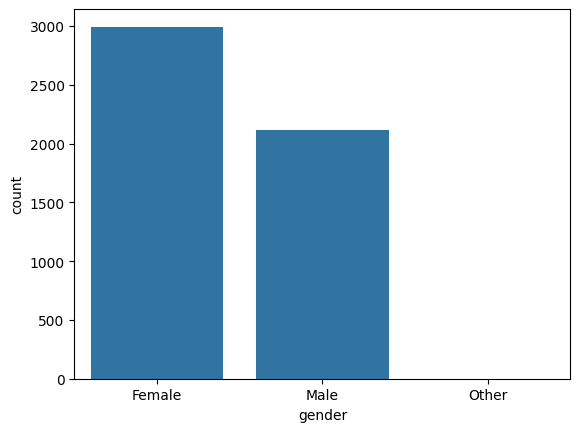

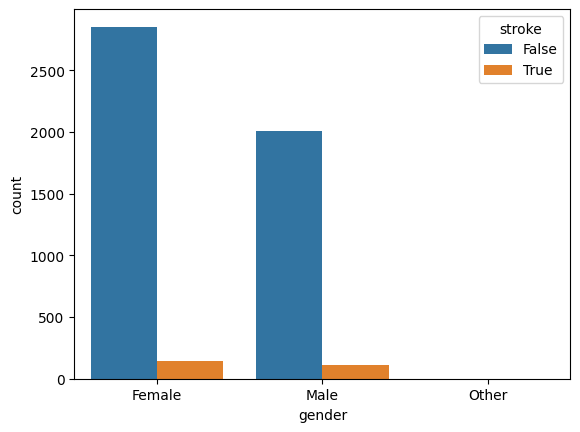

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Print unique values and counts
print('Unique values\n', df['gender'].unique())
print('Value Counts\n', df['gender'].value_counts())

# Plot count plot
sns.countplot(data=df, x='gender')
plt.show()

# Plot count plot with hue for 'stroke'
sns.countplot(data=df, x='gender', hue='stroke')
plt.show()


``` we can see there is not much difference between stroke rate concerning gender. ```

### Histogram 

Summary Statistics for 'age':
Mean: 43.226614481409
Median: 45.0
Mode: 78.0
Standard Deviation: 22.61264672311349
Skewness: -0.1370190866396024
Kurtosis: -0.9912147700517671


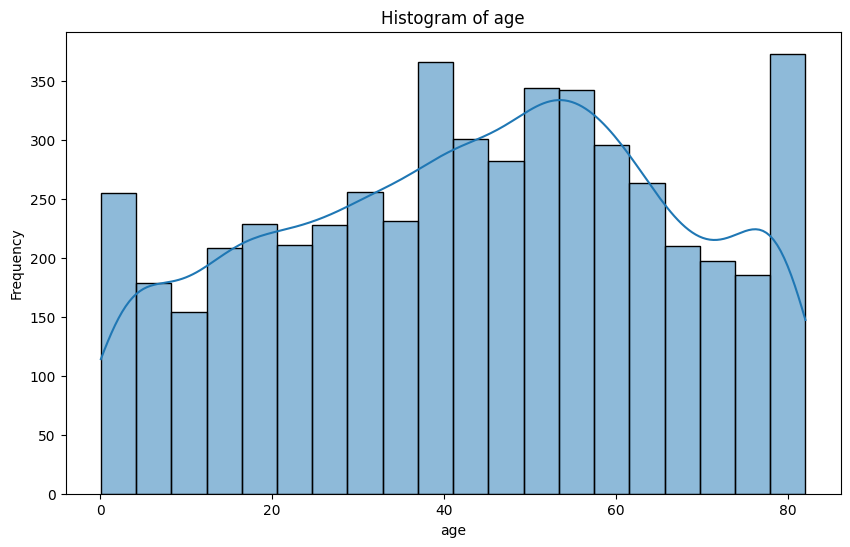

Summary Statistics for 'avg_glucose_level':
Mean: 106.1476771037182
Median: 91.88499999999999
Mode: 93.88
Standard Deviation: 45.28356015058198
Skewness: 1.571822297397199
Kurtosis: 1.6776607484156187


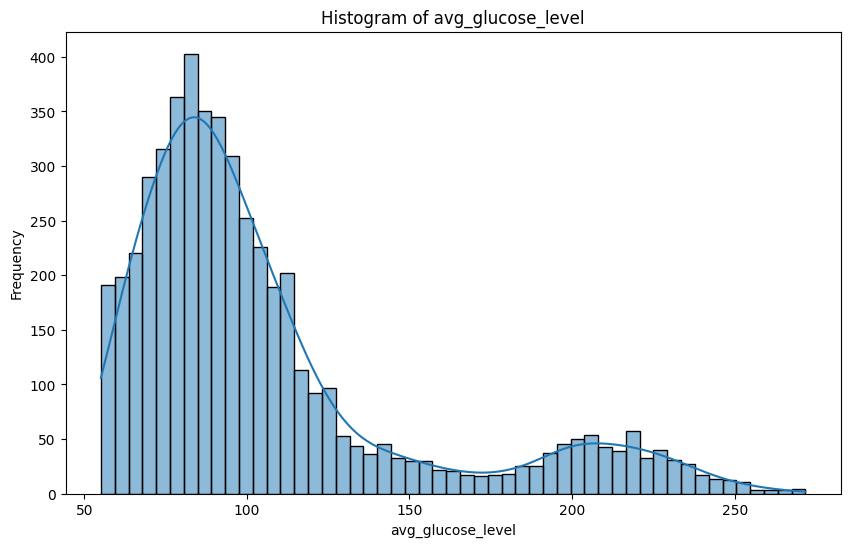

Summary Statistics for 'bmi':
Mean: 28.91841033735874
Median: 28.3
Mode: 28.7
Standard Deviation: 7.73184131003912
Skewness: 1.0471150922521133
Kurtosis: 3.5000214661741333


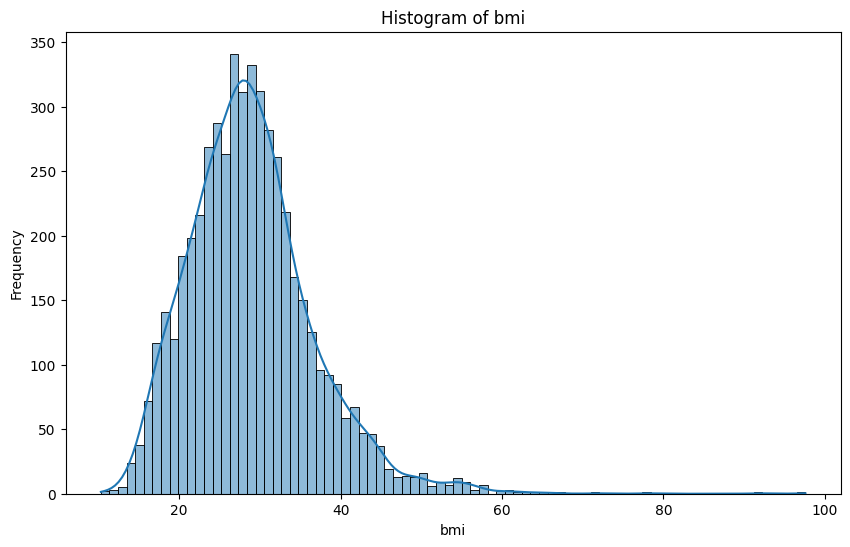

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

# Define numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Loop through each numerical column for analysis
for col in numerical_cols:
    # Summary statistics
    mean = df[col].mean()
    median = df[col].median()
    mode = df[col].mode()[0]
    std_dev = df[col].std()
    skewness = skew(df[col])
    kurt = kurtosis(df[col])
    
    print(f"Summary Statistics for '{col}':")
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std_dev}")
    print(f"Skewness: {skewness}")
    print(f"Kurtosis: {kurt}")
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()
    

    


```` ````

### Age with Stroke & No Stroke

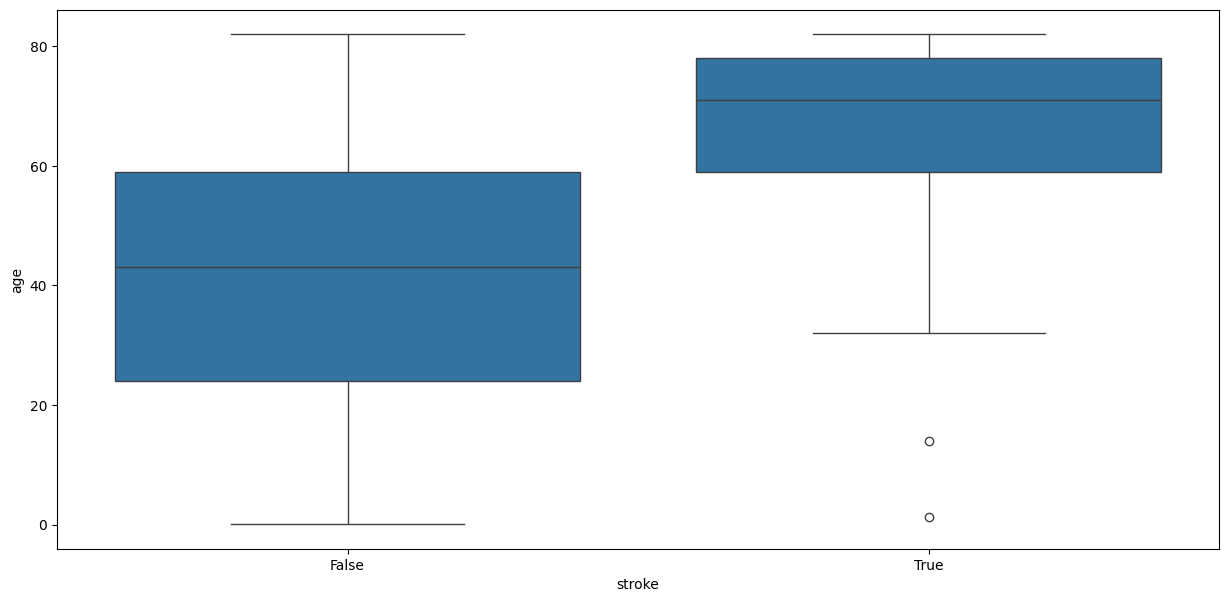

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# This will plot a distribution plot of the variable 'age'
plt.figure(figsize=(15, 7))
sns.boxplot(data=df, x='stroke', y='age')
plt.show()


People aged <b>more than 60 years</b> tend to have a stroke. Some outliers can be seen as people below age 20 are having a stroke it might be possible that it’s valid data as stroke also depends on our eating and living habits. Another observation is people not having strokes also consist of people age > 60 years.

### Hypertension with Stroke & No Stroke

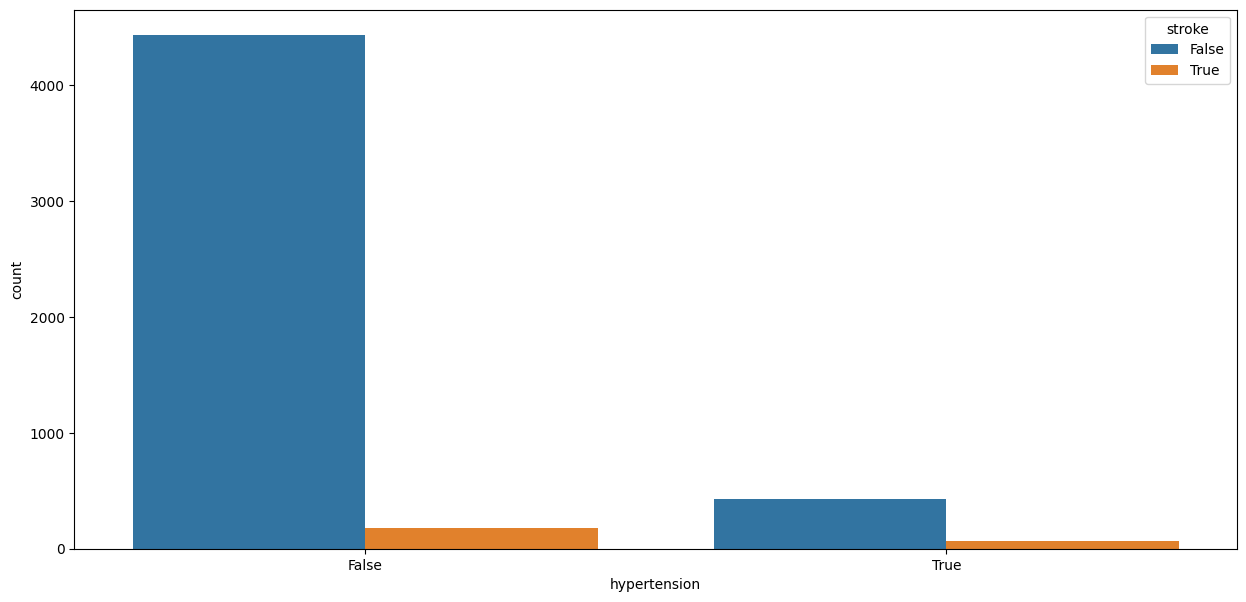

In [22]:
plt.figure(figsize=(15, 7))
sns.countplot(data=df, x='hypertension', hue='stroke')
plt.show()

 Hypertension is rare in young people and common in aged people.It has quite little data on patients having hypertension.

### Heart Disease with Stroke & No Stroke

Unique Values
 [ True False]
Value Counts
 heart_disease
False    4834
True      276
Name: count, dtype: int64


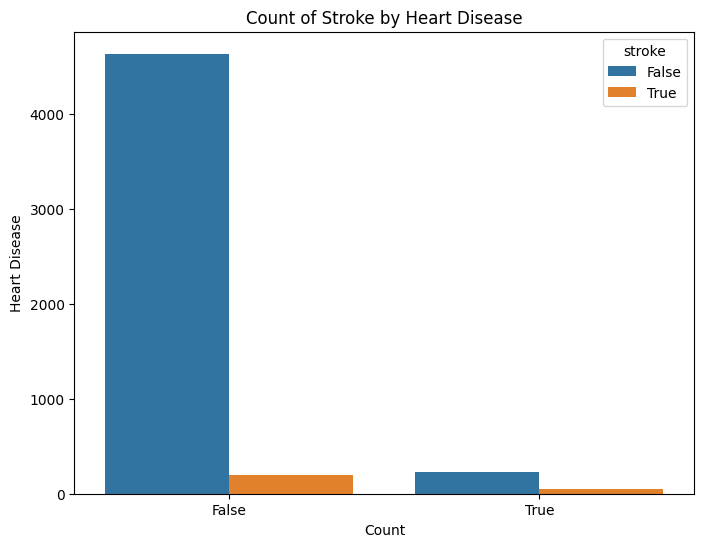

In [27]:
print('Unique Values\n', df['heart_disease'].unique())
print('Value Counts\n', df['heart_disease'].value_counts())

# Create a count plot with 'heart_disease' on the y-axis and 'stroke' on the x-axis
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='heart_disease', hue='stroke')
plt.xlabel('Count')
plt.ylabel('Heart Disease')
plt.title('Count of Stroke by Heart Disease')
plt.show()

Because of the imbalanced dataset, it’s a little bit difficult to get an idea. But as per this plot, we can say that heart disease is not affecting Stroke.

### 

Unique Values
 ['Yes', 'No']
Categories (2, object): ['No', 'Yes']
Value Counts
 ever_married
Yes    3353
No     1757
Name: count, dtype: int64


Text(0.5, 1.0, 'Count of Stroke by Ever Married')

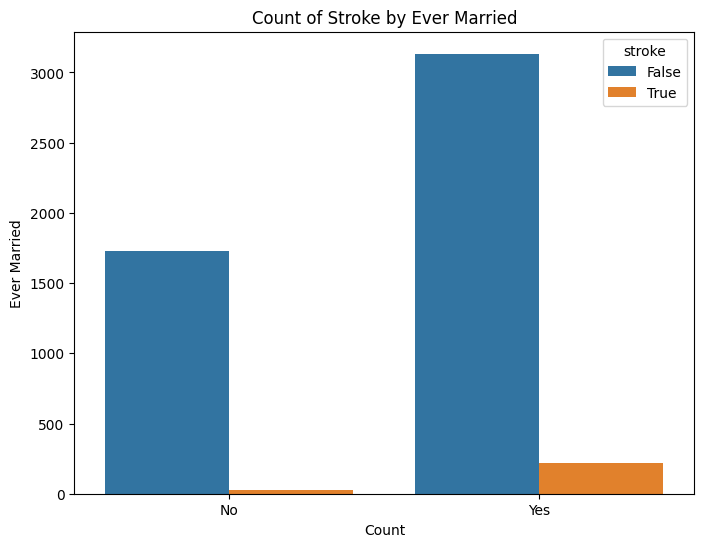

In [30]:
print('Unique Values\n',df['ever_married'].unique())
print('Value Counts\n',df['ever_married'].value_counts())
plt.figure(figsize=(8, 6))
sns.countplot(data=df,x='ever_married',hue='stroke')
plt.xlabel('Count')
plt.ylabel('Ever Married')
plt.title('Count of Stroke by Ever Married')

People who are married have a higher stroke rate.

Unique Values
 ['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked']
Categories (5, object): ['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children']
Value Counts
 work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64


Text(0.5, 1.0, 'Count of Stroke by Work Type')

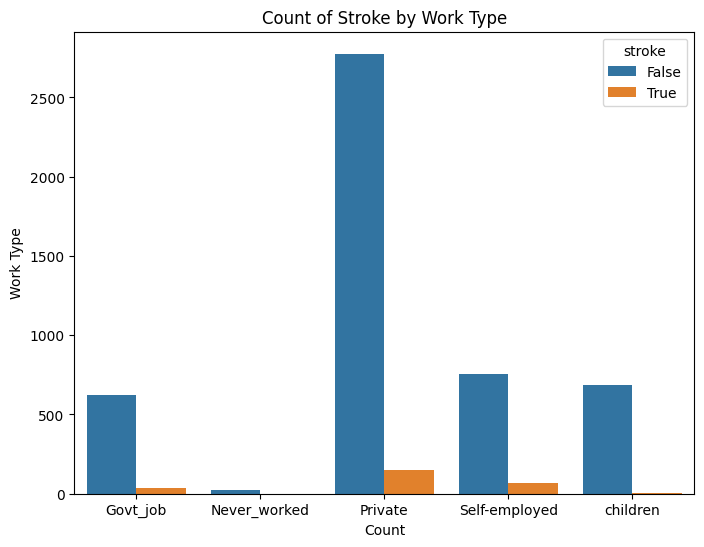

In [32]:
print('Unique Values\n',df['work_type'].unique())
print('Value Counts\n',df['work_type'].value_counts())
plt.figure(figsize=(8, 6))
sns.countplot(data=df,x='work_type',hue='stroke')
plt.xlabel('Count')
plt.ylabel('Work Type')
plt.title('Count of Stroke by Work Type')

People working in the Private sector have a higher risk of getting a stroke. And people who have never worked have a very less stroke rate

### Residence_type

Unique Values
 ['Urban', 'Rural']
Categories (2, object): ['Rural', 'Urban']
Value Counts
 Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64


Text(0.5, 1.0, 'Count of Stroke by Residence_type')

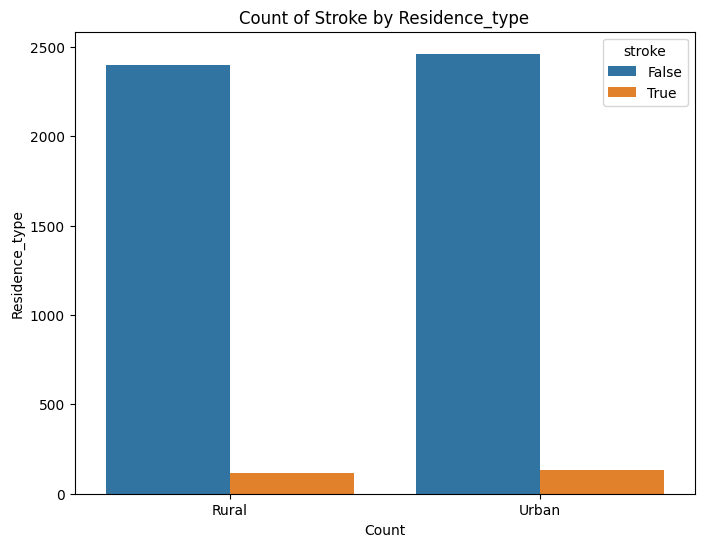

In [33]:
print('Unique Values\n',df['Residence_type'].unique())
print('Value Counts\n',df['Residence_type'].value_counts())
plt.figure(figsize=(8, 6))
sns.countplot(data=df,x='Residence_type',hue='stroke')
plt.xlabel('Count')
plt.ylabel('Residence_type')
plt.title('Count of Stroke by Residence_type')

This attribute is of no use. As we can see there not much difference in both attribute values. Maybe we have to discard it.

### BMI


<Axes: xlabel='bmi', ylabel='Count'>

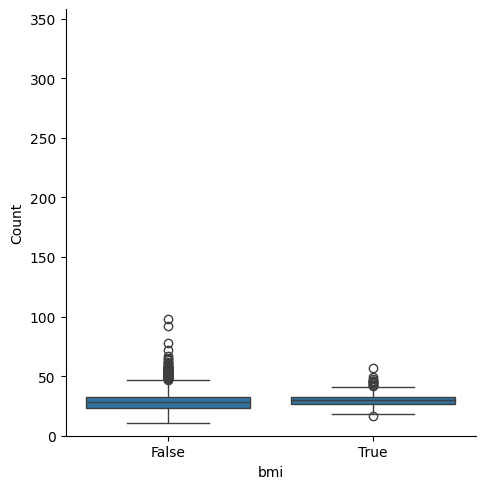

In [37]:
# Filling null values in 'bmi' with the mean value
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

# Plotting distribution of 'bmi'
sns.displot(df['bmi'])

# Plotting boxplot of 'bmi' with respect to 'stroke'
sns.boxplot(data=df, x='stroke', y='bmi')

# BMI with respect to Stroke

There is as such no prominent observation of how does BMI affects the chances of having a stroke.

### Smoking Status

Unique Values
 ['formerly smoked', 'never smoked', 'smokes', 'Unknown']
Categories (4, object): ['Unknown', 'formerly smoked', 'never smoked', 'smokes']
Value Counts
 smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64


Text(0.5, 1.0, 'Count of Stroke by smoking_status')

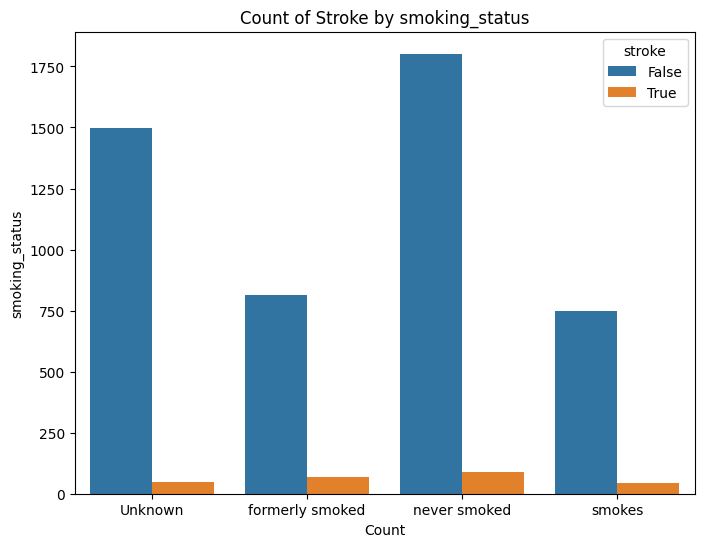

In [38]:
print('Unique Values\n',df['smoking_status'].unique())
print('Value Counts\n',df['smoking_status'].value_counts())
plt.figure(figsize=(8, 6))
sns.countplot(data=df,x='smoking_status',hue='stroke')
plt.xlabel('Count')
plt.ylabel('smoking_status')
plt.title('Count of Stroke by smoking_status')

As per these plots, we can see there is not much difference in the chances of stroke irrespective of smoking status.

### Outliners

In [23]:
 Q1 = df[col].quantile(0.25)
 Q3 = df[col].quantile(0.75)
 IQR = Q3 - Q1
 outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))]
 if len(outliers) > 0:
        print(f"Outliers detected in '{col}':")
        print(outliers)
 else:
        print(f"No outliers detected in '{col}'")
 print("\n")

Outliers detected in 'bmi':
      gender   age  hypertension  heart_disease ever_married      work_type  \
21    Female  52.0          True          False          Yes  Self-employed   
66    Female  70.0         False          False          Yes        Private   
113   Female  45.0         False          False          Yes        Private   
254   Female  47.0         False          False          Yes        Private   
258   Female  74.0          True          False          Yes  Self-employed   
...      ...   ...           ...            ...          ...            ...   
4906  Female  53.0         False          False          Yes        Private   
4952    Male  51.0          True          False          Yes  Self-employed   
5009  Female  50.0         False          False          Yes  Self-employed   
5057  Female  49.0         False          False          Yes       Govt_job   
5103  Female  18.0         False          False           No        Private   

     Residence_type  av

### Feature Engineering

#### Label Encoding

In [42]:
cols=df.select_dtypes(include=['object']).columns
print(cols)
# This code will fetech columns whose data type is object.
le=LabelEncoder()
# Initializing our Label Encoder object
df[cols]=df[cols].apply(le.fit_transform)
# Transfering categorical data into numeric
print(df.head(10))

Index([], dtype='object')
   gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0         False           True          Yes        Private   
1  Female  61.0         False          False          Yes  Self-employed   
2    Male  80.0         False           True          Yes        Private   
3  Female  49.0         False          False          Yes        Private   
4  Female  79.0          True          False          Yes  Self-employed   
5    Male  81.0         False          False          Yes        Private   
6    Male  74.0          True           True          Yes        Private   
7  Female  69.0         False          False           No        Private   
8  Female  59.0         False          False          Yes        Private   
9  Female  78.0         False          False          Yes        Private   

  Residence_type  avg_glucose_level        bmi   smoking_status  stroke  
0          Urban             228.69  36.600000  formerly smoked

#### Correlation

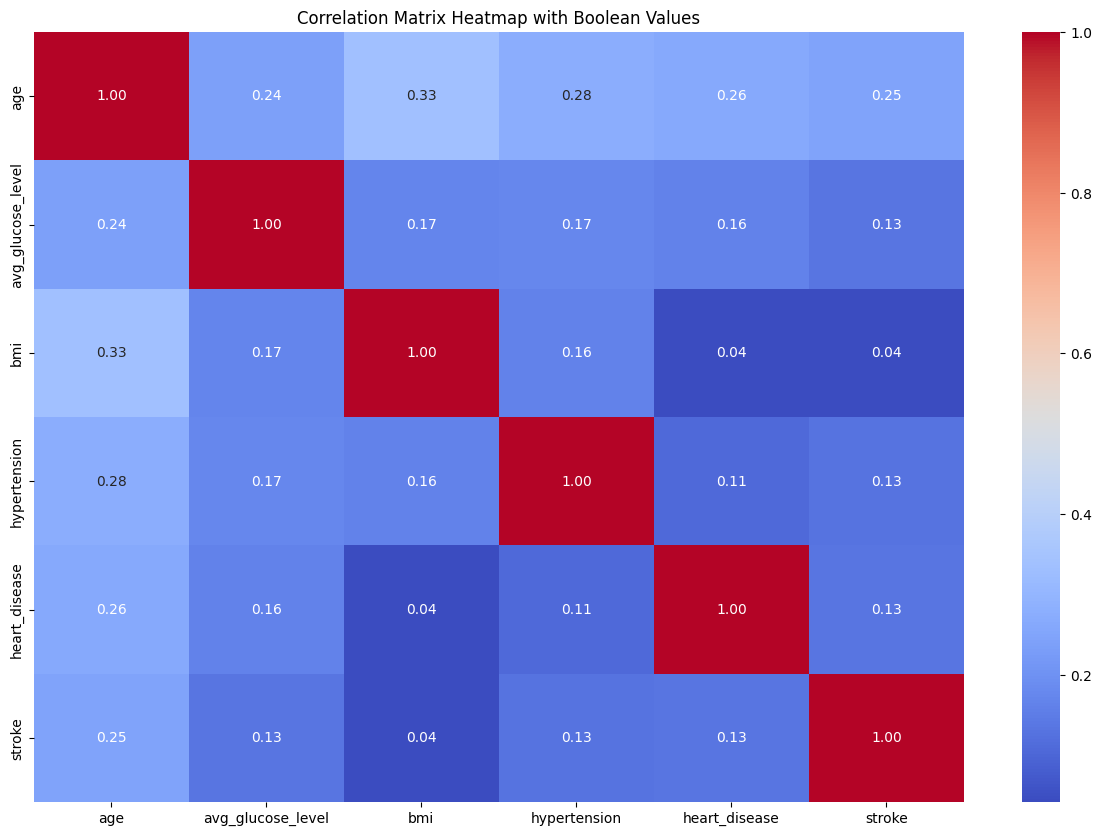

In [51]:
# Convert boolean columns to numerical values (0 for False, 1 for True)
boolean_df = df.select_dtypes(include=['bool']).astype(int)

# Concatenate numerical and boolean columns
numerical_boolean_df = pd.concat([numerical_df, boolean_df], axis=1)

plt.figure(figsize=(15, 10))

# Plot correlation matrix heatmap
sns.heatmap(numerical_boolean_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix Heatmap with Boolean Values')
plt.show()


## correlation matrices

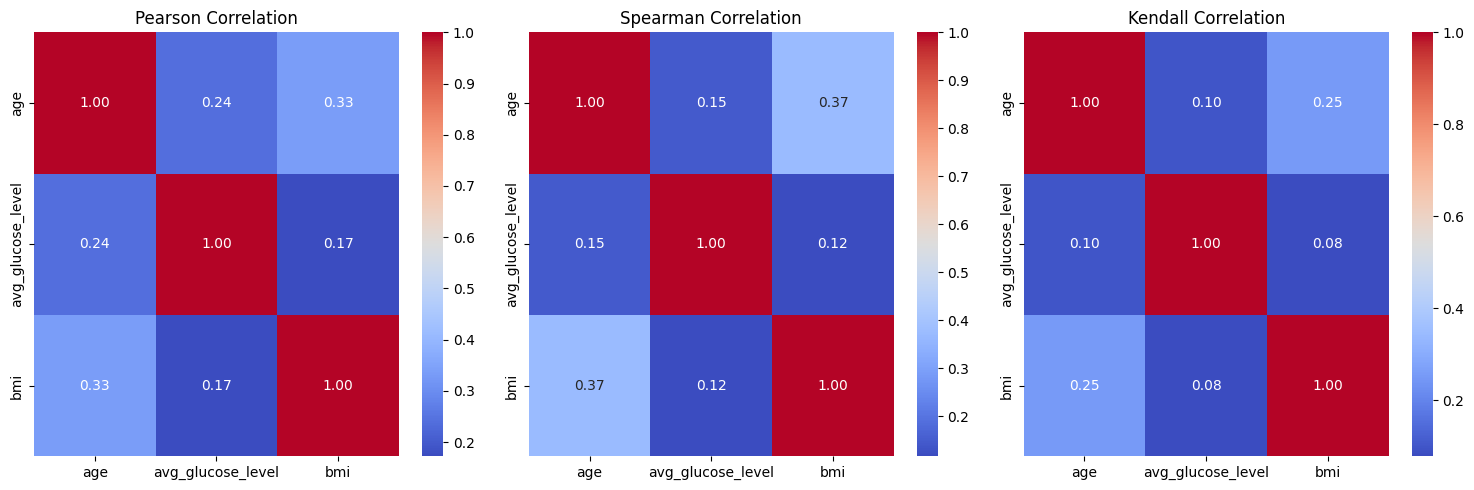

In [34]:
# Select numerical columns for correlation matrix
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Calculate correlation matrices using different methods
pearson_corr = numerical_df.corr(method='pearson')
spearman_corr = numerical_df.corr(method='spearman')
kendall_corr = numerical_df.corr(method='kendall')

# Plot correlation matrices
plt.figure(figsize=(15, 5))

# Pearson correlation
plt.subplot(1, 3, 1)
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Pearson Correlation')

# Spearman correlation
plt.subplot(1, 3, 2)
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Spearman Correlation')

# Kendall correlation
plt.subplot(1, 3, 3)
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Kendall Correlation')

plt.tight_layout()
plt.show()


#### This suggest that the relationships between variables in the dataset are consistent across different types of correlations

The value in the first row and first column (1.0) represents the correlation between Pearson Correlation and itself, which is obviously 1.0. Similarly, the value in the fourth row and first column (0.24) represents the correlation between Pearson Correlation and age, and the value in the fourth row and second column (1.00) represents the correlation between age and itself, which is also 1.0,Suggesting that the values are the same in the table because they represent the correlation between the same two variables.

In [50]:
# Calculate skewness for each numerical column
skewness_values = df.select_dtypes(include=['int64', 'float64']).apply(lambda x: x.skew())

# Display skewness values
print("Skewness of Columns:")
print(skewness_values)


Skewness of Columns:
age                 -0.137059
avg_glucose_level    1.572284
bmi                  1.047423
dtype: float64
